# Environment setup

In [295]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Library preparation

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [354]:
import time, os, io, clipboard
from PIL import ImageGrab
from IPython.display import Image, display
from scipy import stats
from si_prefix import si_format
from math import *
from tqdm import tqdm, tqdm_notebook

from io import StringIO 
import pandas as pd
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

import sys 
sys.path.append('..')
from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment, experiments)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

### Database ini

In [3]:
SAMPLE = '79N6'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

## Scripts

### Data proc

In [4]:
def extract_Isw_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']

        
    return extract_Isw (Is,Vs)

def extract_Isw (Is,Vs):
    
        if len( Is )== 0 or len( Vs )== 0 :
            Isw, R0 = np.nan, np.nan
            return Isw, R0
        
        Isw = abs(np.max(Is)) 
        

        
        return Isw

In [5]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [6]:
def xy_by_id(idx):
    alldata = get_data_by_id(idx)
    
    x = alldata[0][0]['data']
    y = alldata[0][1]['data']
    
    return x,y

In [54]:
def batch_plot_by_id(ids, ax = None, labels = None, **kw):
    if ax is None:
        fig, ax = plt.subplots()
        
    for i, idx in enumerate(ids):
        if labels is not None:
            label = labels[i]
        else:
            label = ''
            
        plot_by_id(idx, axes = ax, label = label, **kw)
        
    ax.legend()
    

In [357]:
def JJpar(RN, JJwidthUM=0.2, metalTHK=250E-10, Tc=1.34):
   
    Rs_JJ = RN * ( (JJwidthUM*1E-6 + 2*metalTHK) *JJwidthUM*1E-6 )
    IAB = const.pi *1.764 *const.k *Tc /2 /const.e /RN
    EJ_JJ = const.h /2 /const.e /2 /const.pi *IAB
    C_JJ = 50E-15 *JJwidthUM *JJwidthUM
    EC_JJ = const.e *const.e /2 /C_JJ
    C0 = ParplateCap(area= 56*1E-12 , dielecTHK=10E-9, epsilon = 9.34*const.epsilon_0)
    EC0 = const.e *const.e /2 /C0
   
    freqPlasma = sqrt(2 *const.e *IAB *2*const.pi /const.h /max(C0,C_JJ)) /2/const.pi
    Q = freqPlasma*2*pi *RN *max(C0,C_JJ)
    EJoEc = EJ_JJ/min(EC0,EC_JJ)

#     key =  [ 'RN_JJ',   'Rs_JJ', 'I_AB',   'EJ', 'C_JJQP',   'EC', 'C0', 'EC0', 'Freq_plasma', 'Q', 'Beta', 'EJ/EC']
#     unit=  [   'ohm', 'ohm-m^2',    'A',    'J',      'F',    'J',  'F',   'J',          'Hz',  '',     '',      '']
#     lst = [[     RN ,    Rs_JJ ,   IAB , EJ_JJ ,    C_JJ , EC_JJ ,  C0 ,  EC0 ,    freqPlasma,  Q ,   Q*Q ,  EJoEc ]]
    key =  [ 'RN_JJ',    'Rs_JJ', 'I_AB',           'EJ',  'C_JJQP',          'EC',    'C0',       'EC0',  'Freq_plasma', 'Q', 'Beta', 'EJ/EC']
    unit=  [  'kohm','kohm*um^2',   'nA',            'K',      'fF',           'K',    'fF',         'K',          'GHz',  '',     '',      '']
    lst = [[ RN/1e3 , Rs_JJ*1e9 ,IAB*1e9, EJ_JJ/const.k , C_JJ*1e15, EC_JJ/const.k, C0*1e15, EC0/const.k, freqPlasma/1e9,  Q ,   Q*Q ,  EJoEc ]]
    JJparDFM =   pd.DataFrame(  data  = list(zip(*lst)),
                                index = key ).transpose()
    JJparUNI =   dict(zip(key, unit))

    return JJparDFM,JJparUNI

def ParplateCap(area, dielecTHK, epsilon = 9.34*const.epsilon_0):
    C = epsilon *area /dielecTHK
    return C

In [373]:
devlst = {'D079N1': JJpar(RN=  290e3/.5, JJwidthUM=np.sqrt( .177 *  .177)),
          'D079N3': JJpar(RN=  520e3/ 8, JJwidthUM=np.sqrt( .784 *  .263)),
          'D079N5': JJpar(RN=   27e3/ 8, JJwidthUM=np.sqrt( 2.25 *  1.74)),
          'D079N6': JJpar(RN= 2.15e3/.5, JJwidthUM=np.sqrt( 2.21 *  1.72)),
          'D079N0': JJpar(RN= 24.3e3/ 8, JJwidthUM=np.sqrt( 2.21 *  1.67))}

a     = devlst['D079N1'][0]
unit  = devlst['D079N1'][1]
idlst = []
for dev in devlst:
    a = a.merge(devlst[dev][0], 'outer')
    idlst.append(dev)
   
a.insert(loc = 0, column = 'dev id', value = idlst)
a

,dev id,RN_JJ,Rs_JJ,I_AB,EJ,C_JJQP,EC,C0,EC0,Freq_plasma,Q,Beta,EJ/EC
0,D079N1,580.0000,23.303820,0.551656,0.013150,1.56645,0.593460,463.10944,0.002007,0.302792,511.017683,261139.072095,6.550834
1,D079N3,65.0000,14.878252,4.922465,0.117337,10.30960,0.090171,463.10944,0.002007,0.904486,171.071873,29265.585666,58.453599
2,D079N5,3.3750,13.547020,94.803031,2.259825,195.75000,0.004749,463.10944,0.002007,3.969370,38.981525,1519.559256,1125.773023
3,D079N6,4.3000,16.764338,74.409355,1.773700,190.06000,0.004891,463.10944,0.002007,3.516610,44.000353,1936.031052,883.600919
4,D079N0,3.0375,11.502271,105.336701,2.510917,184.53500,0.005038,463.10944,0.002007,4.184083,36.981121,1367.603330,1250.858914


#### Hist

In [296]:
def load_hist_by_id(idx):
    _, Isws = xy_by_id(idx)
    return Isws

In [8]:
def plot_hist_by_id(idx, ax = None):
    _, Isws = xy_by_id(idx)
    if ax is None:

        fig, ax = plt.subplots()

    ax.hist(Isws, bins = 201, cumulative = True )
    return Isws

In [9]:
def save_hist(Isws, label = ''):     
    N_try = qc.Parameter('try')    

    meas = set_meas( Isrc.I, N_try, setup = setup, cleanup = cleanup)
    name = '{:} @T ={:2.1f}mK'.format(label, T8.get()/1e-3)
    name_exp(sample = SAMPLE, exp_type = name )  
    with meas.run() as datasaver: 
        for j, I in enumerate(Isws):
            res = [ ( N_try, j  ) ,( Isrc.I, I ),]

            datasaver.add_result(*res)
            
    print('Run # {:1.0f}, {:} saved'.format(datasaver.run_id, name))

In [317]:
def fit_hist_by_id(idx, EJ = 4, Ec = 0.05, dIdt = 30e-9, bins = 21):

    def wpK(EjK, EcK):
        return np.sqrt(8*EjK*EcK)
    
    eps = .001
    
    Isw = abs(load_hist_by_id(idx ))

    counts, Ibins = np.histogram(Isw, bins = bins)
    dI = np.mean( np.diff(Ibins) )

    SP = np.cumsum(counts)/len(Isw)
    Gamma = np.array([ np.log( (1 - SP[i])/(1 - SP[i+1]) ) for i in range(len(SP)-1)  ])*dIdt/dI


    Ic = 2*pi*EJ/Φ0*kB
    Ic0 = 1.5 * np.max(Isw)
    Ib = Ibins[:-2]
    
    while abs((Ic - Ic0)/Ic) > eps:
        Ic = Ic0
        wa = wpK(EJ, Ec)*kB/hbar/2/pi * (1 - (Ib/Ic)**2)**0.25

        coeff =  (-np.log(2*pi*Gamma/wa))**(2/3)
        i = np.isfinite(coeff) 
        
        a, b = np.polyfit( Ib[i], coeff[i],1)
        Ic0 = -b/a
        Teff = -1/kB*Φ0/2/pi*4*np.sqrt(2)/3 /np.sqrt(b)/a
    

    return Ic0, Teff

In [315]:
# def fit_plot_hist_by_id(idx, ax = None, EJ = 4, 
#                         Ec = 0.05,dIdt = 30e-9, bins = 21):

#     eps = .001
    
#     Isw = abs(load_hist_by_id( idx ))

#     counts, Ibins = np.histogram(Isw, bins = bins)
    
#     Ib = Ibins[:-2]
    
#     Ic0, Teff, coeff = fit_hist_by_id(idx, EJ = EJ, Ec = Ec,
#                                dIdt = dIdt, bins = bins)
#     print( Ic0, Teff )  

#     if ax is None:
#         fig, ax = plt.subplots()
#         add_legend = True
#     else:
#         add_legend = False
#     l = ax.plot(Ib, coeff, 'x')
#     c = l[0].get_color()
    
#     Iplot = np.linspace(np.min(Ib), Ic0, 101)
#     ax.plot(Ib, a*Ib + b, c = c, ls = '--', 
#             label = 'Tesc = {:1.0f} mK, Ico = {:1.0f} nA'. format(Teff/1e-3, Ic0*1e9))
#     if add_legend:
#         ax.legend()

#     return ax
    

## Measurement plan

- check TA-UPD transition
- compare AWG and Keith for the same scanning time 

#### Constants

In [298]:
ZF =  0.004e-3
FF =  0.224e-3
dF = 0.250e-3
midF = 0.154e-3

from scipy.constants import e, hbar,h, k, pi

Φ0 = h/2/e 
kB = k
Δ = 2.1*kB

## KK 12/17

Plan:

- meas full IVC & TA transition 
- extract Q(0) and Q(wp)
- compare AWG and Keith with the same delay

###  Full IVC

    Meas IVC to extract Ir0, RN to find Q(0) and wp?

<IPython.core.display.Javascript object>


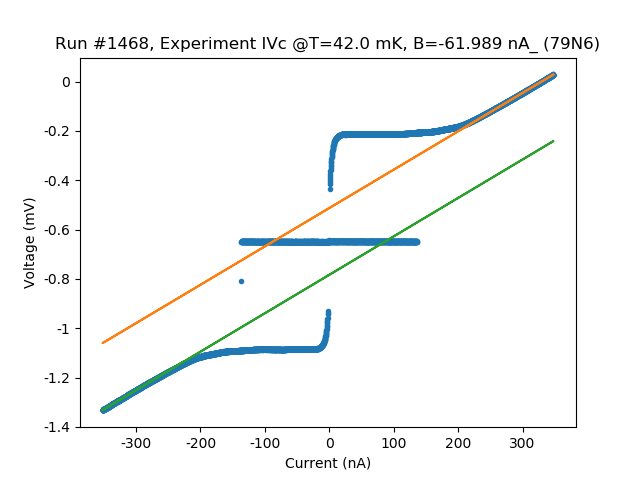

1556.2266489001531 -0.0005125877870277452
1558.7091069849719 -0.0007833524696328562


In [47]:
fig, ax = plt.subplots()

plot_by_id(1468, axes = ax, marker = '.', ls = '')

I, V = xy_by_id(1468)

for cond in [ I > 300e-9 , I < -300e-9]:
    idx = np.where(cond)

    a,b = np.polyfit(I[idx], V[idx], 1)

    print(a,b)

    ax.plot(I, I*a + b)

In [46]:
2*1.6e-19/135e-6

2.37037037037037e-15

In [59]:
RN = 1.56e3
C = 2.37e-15
Ic0 = 200e-9
wp = (2*e*Ic0/hbar/C)**.5
wp/1e9/2/pi

80.59221135206005

In [60]:
200/wp/C

166651.3011625993

RN = 1.56 kOhm

Intercept = 135 uV = 2e/C
C = 2.37 fF


Ic = 200 nA (from hyst + Rn meas)

Q(0) = 4/$\pi$ Ic0/Ir0 = 4/3.14*200/1.2 > 200

wp = 80 GHz ??

Q = wpRC, R(0) = Q/wp/C = 160 kOhm


### TA -UPD transition
    Meas IVC and hist for cos in [.3 - .1] to see narrowing of the distribution/emerging of R0

#### AWG

<IPython.core.display.Javascript object>


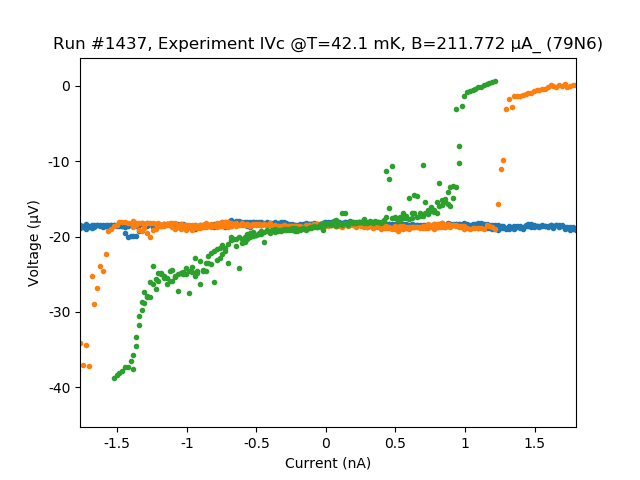

In [61]:
# IVC for cos = [.25, .2, .15]
batch_plot_by_id([1435, 1436,1437], marker = '.', ls = '')

<IPython.core.display.Javascript object>


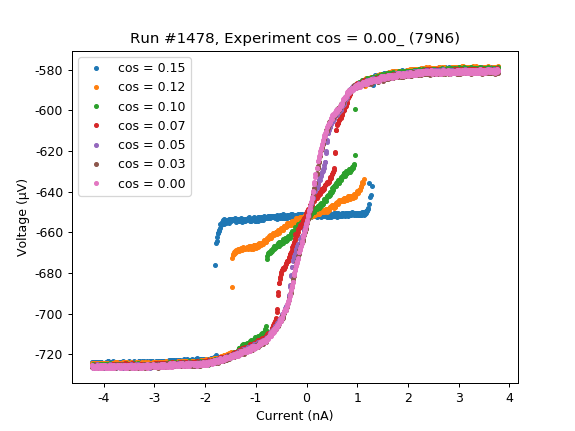

In [194]:
# IVC for cos = np.linspace(.15, 0, 7)
labels = [ 'cos = {:1.2f}'.format(cos) for cos in np.linspace(.15,0,7)]
batch_plot_by_id(range(1472,1478+1),
                 labels = labels,marker = '.', ls = '')

Presumably cos = .15 corresponds to PD. 
Isw = 4/pi*Ic0*cos/Q(wp) = 1 nA
Q(wp) = 40
R(wp) = 33e3

But wp(cos)~ cos**.5, so

R(wp*) = 86e3

#### Mess with Keithley

<IPython.core.display.Javascript object>


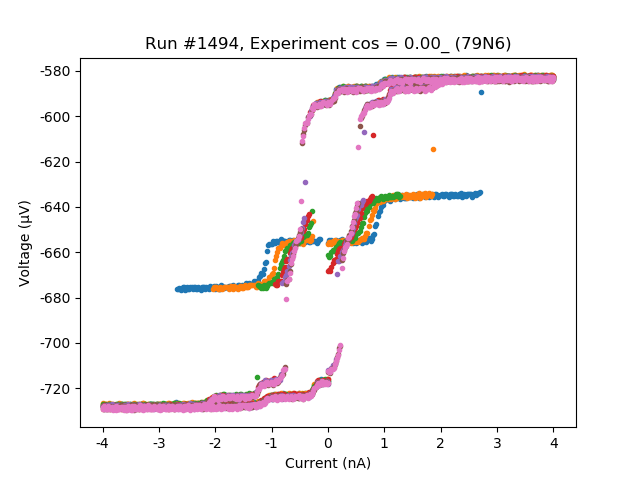

In [92]:
batch_plot_by_id(range(1488,1494+1), marker = '.', ls = '')

wth, there are two copies of IV?? although it looks better than awg. 
Measure .1 and .05 for timedelay = .5

<IPython.core.display.Javascript object>


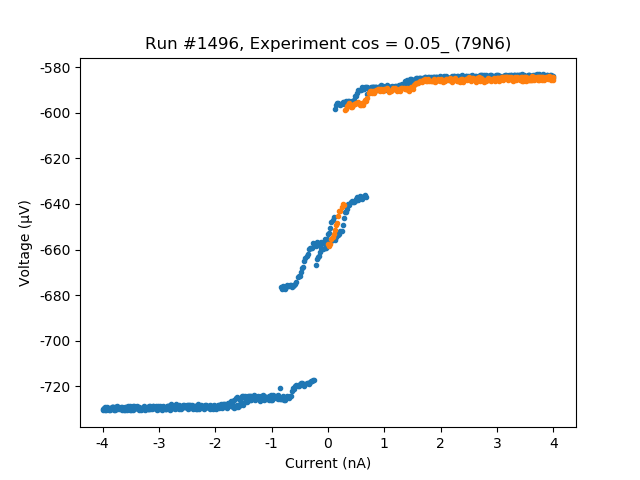

In [101]:
batch_plot_by_id(range(1495,1496+1), marker = '.', ls = '')

Ok, it helps. Probably this is due 100 MOhm I have to use in this region. Also should switch to range('fast 6')

tfsstb = 0.1, but fast 6

<IPython.core.display.Javascript object>


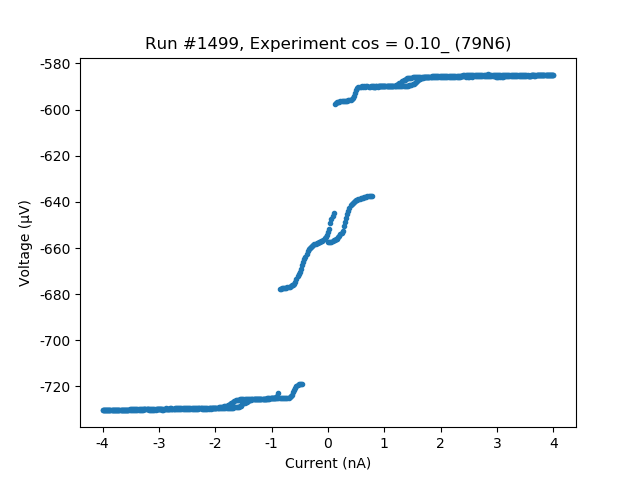

In [110]:
batch_plot_by_id(range(1499,1499+1), marker = '.', ls = '')

tfsstb = 0.25

No difference(

<IPython.core.display.Javascript object>


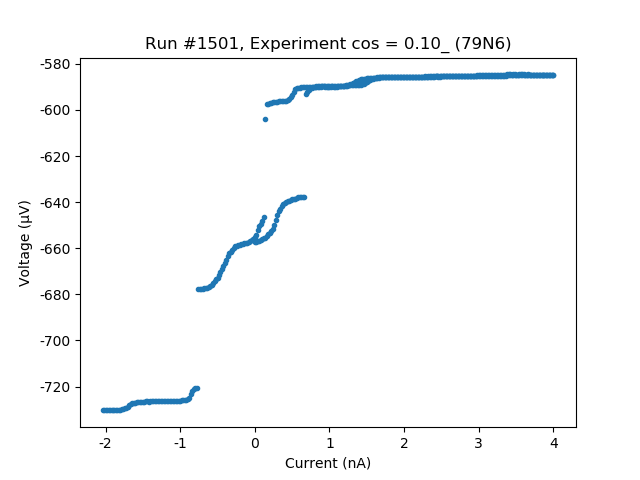

In [117]:
batch_plot_by_id(range(1501,1501+1), marker = '.', ls = '')

tfsstb = 1

better, but do we need that R at all? Keithley is a current source.. 

<IPython.core.display.Javascript object>


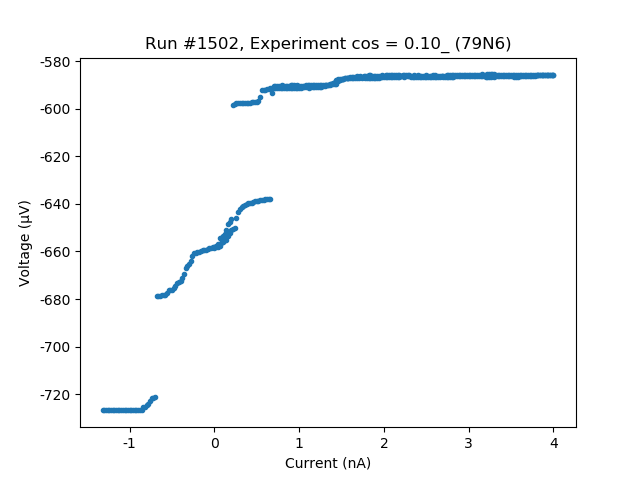

In [123]:
batch_plot_by_id(range(1502,1502+1), marker = '.', ls = '')

Put 1 MhOm only, 0.1 timedelay

<IPython.core.display.Javascript object>


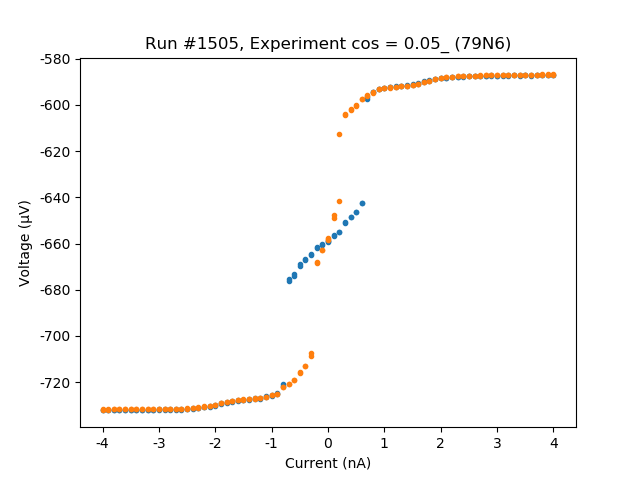

In [11]:
batch_plot_by_id(range(1504,1505+1), marker = '.', ls = '')

Yay, works! Question is how to change ranges(now .1nA is limit)

<IPython.core.display.Javascript object>


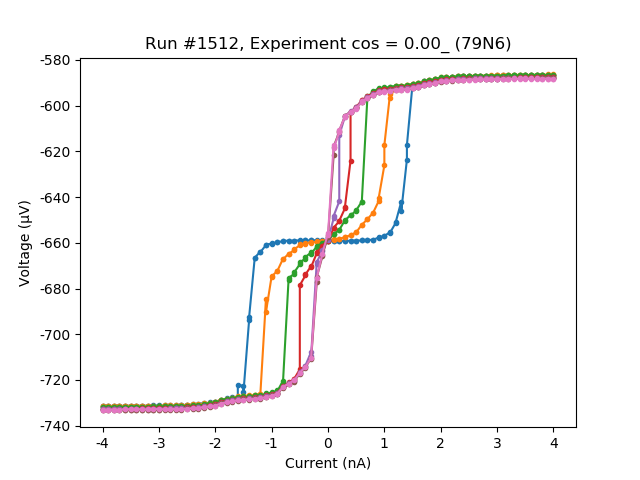

In [16]:
# IVC for cos = np.linspace(.15, 0, 7)
batch_plot_by_id(range(1506,1512+1), marker = '.', ls = '-')

#### Low cos with Keith
    

<IPython.core.display.Javascript object>


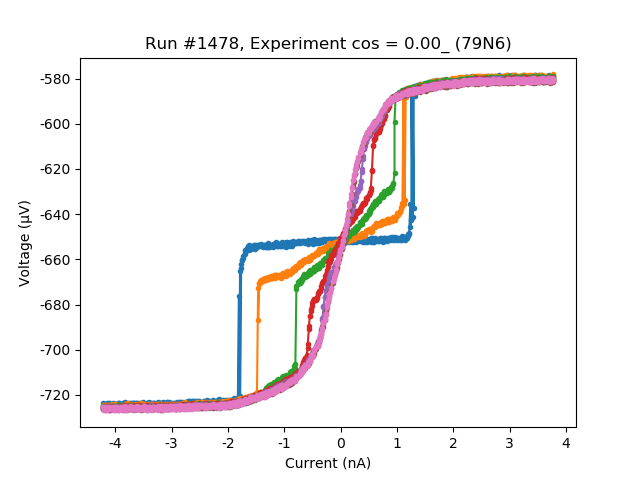

In [15]:
# Reminder - AWG
batch_plot_by_id(range(1472,1478+1), marker = '.', ls = '-')

hm, what anout fast 4? (and .02 nA stepsize - changed range manually)


<IPython.core.display.Javascript object>


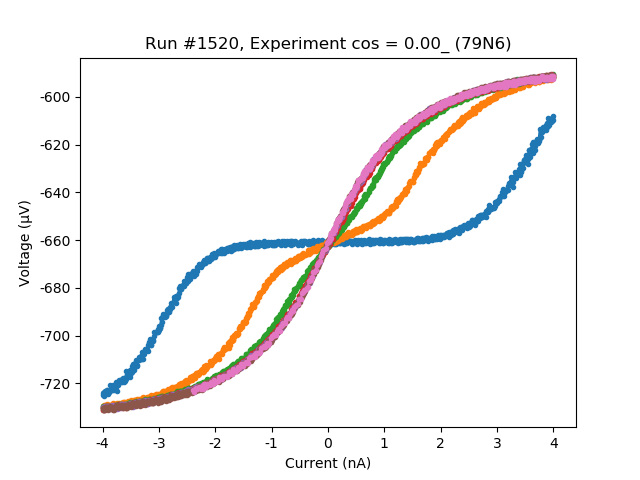

In [27]:
batch_plot_by_id(range(1514,1520+1), marker = '.', ls = '-')

Compare AWG and Keithley at cos = .15

<IPython.core.display.Javascript object>


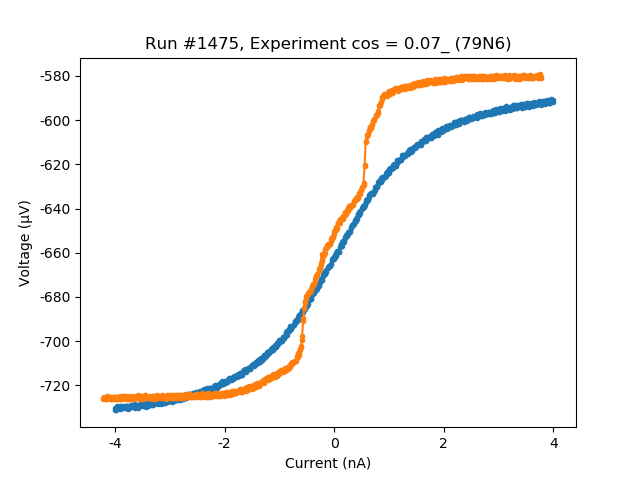

In [26]:
i = 3
batch_plot_by_id([1514+i, 1472+i], marker = '.', ls = '-')

Looks smoother, but is it effect of noise? try fast 6 (or value of ext rtesistor drives the system to the overdamped regime??)

same as fast 4

<IPython.core.display.Javascript object>


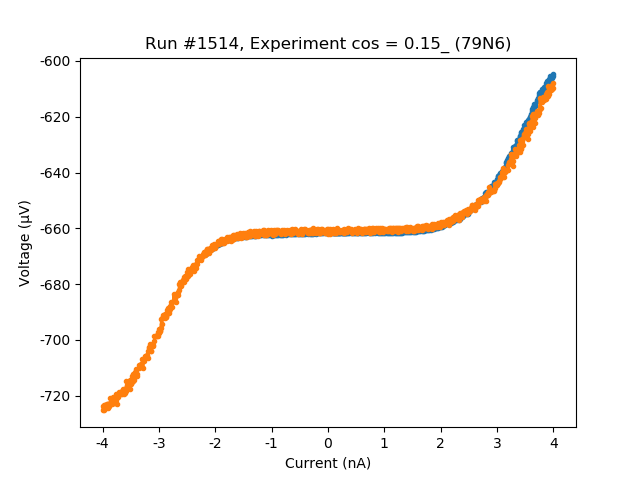

In [33]:
batch_plot_by_id([1521, 1514], marker = '.', ls= '-')

IVC for Keisley in deff regimes (1e-6 vs 1e-7):


<IPython.core.display.Javascript object>


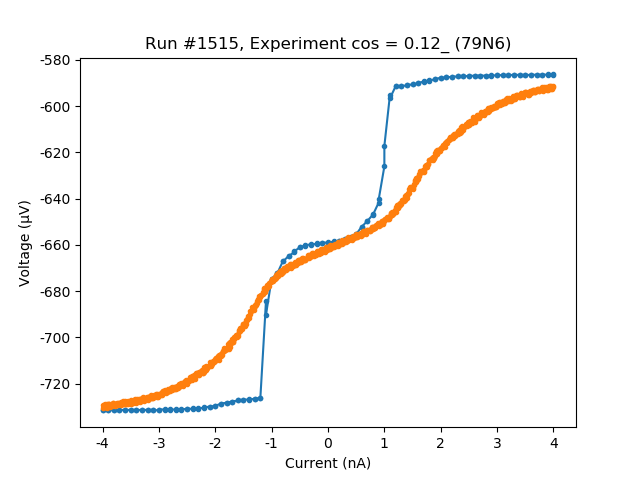

In [30]:
i = 1
batch_plot_by_id([1506+i, 1514+i], marker = '.', ls = '-')

Ok, put 10MOhm

<IPython.core.display.Javascript object>


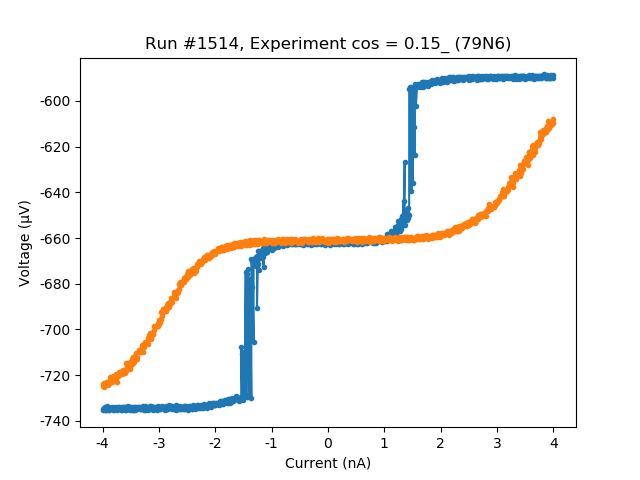

In [40]:
i = 0
batch_plot_by_id([1524+i, 1514+i], marker = '.', ls = '-')

Hm! Put just short (50 ohm) vs 1MOhm

<IPython.core.display.Javascript object>


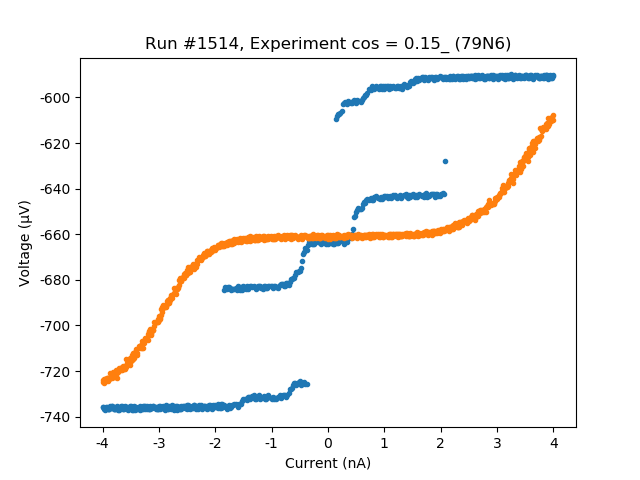

In [52]:
batch_plot_by_id([1530, 1514], marker = '.', ls = '')

#### IVC with diiferent Rload
    have to use tfsstb = 2 since RC cutoff changes with R (even 10 for 100Mohm)

<IPython.core.display.Javascript object>


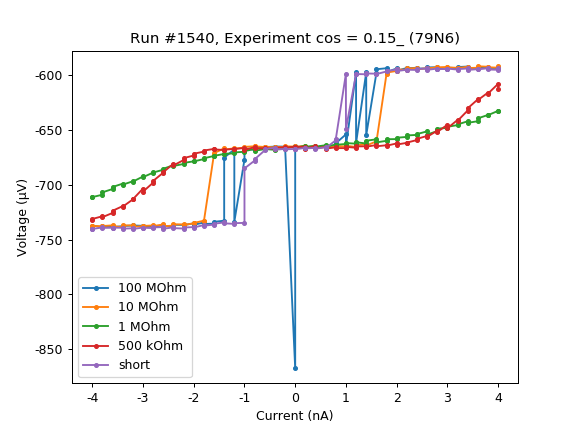

In [101]:
labels = ['100 MOhm', '10 MOhm', '1 MOhm', '500 kOhm', 'short']
batch_plot_by_id([1535, 1536, 1538, 1539, 1540],
                 labels = labels, marker = '.', ls = '-')

100 MOhm for 2 and 10 s

<IPython.core.display.Javascript object>


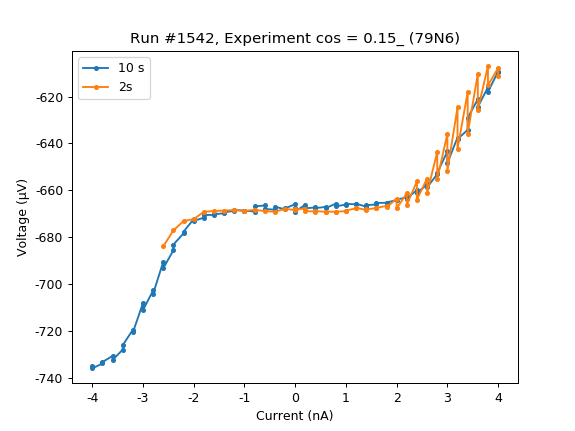

In [98]:
labels = ['10 s', '2s']
batch_plot_by_id([1541, 1542],
                labels = labels, marker = '.', ls = '-')

Doesnt depend on time delay? Ok, repeat 10 MOhm 

<IPython.core.display.Javascript object>


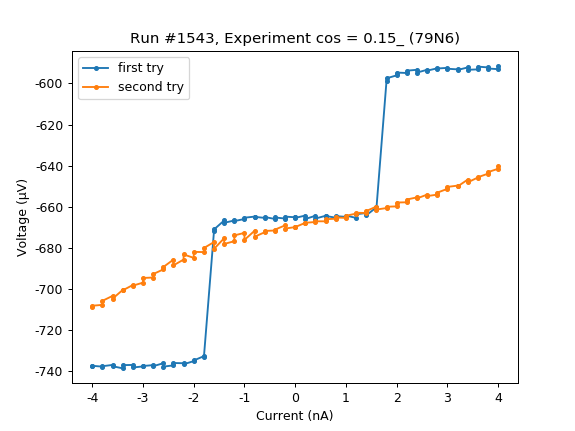

In [102]:
labels = ['first try', 'second try']
batch_plot_by_id([1536, 1543],
                labels = labels, marker = '.', ls = '-')

WTF! Remeas everything

<IPython.core.display.Javascript object>


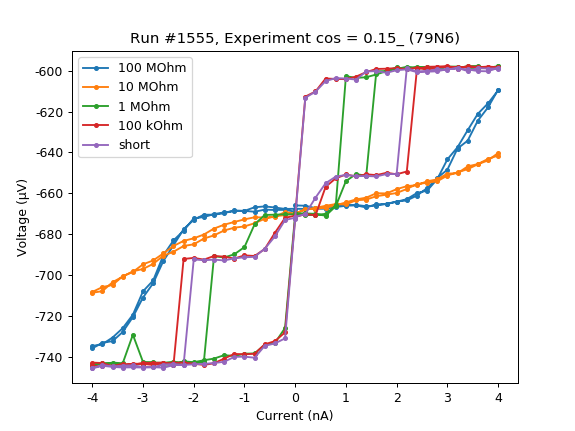

In [152]:
labels = ['100 MOhm', '10 MOhm', '1 MOhm', '100 kOhm', 'short']
batch_plot_by_id([1541, 1543, 1553, 1554, 1555],
                 labels = labels, marker = '.', ls = '-')

somewhat random changes of IVc. or just supression of Isw?
remeas with tfsstb = .1, di = 0.02nA

<IPython.core.display.Javascript object>


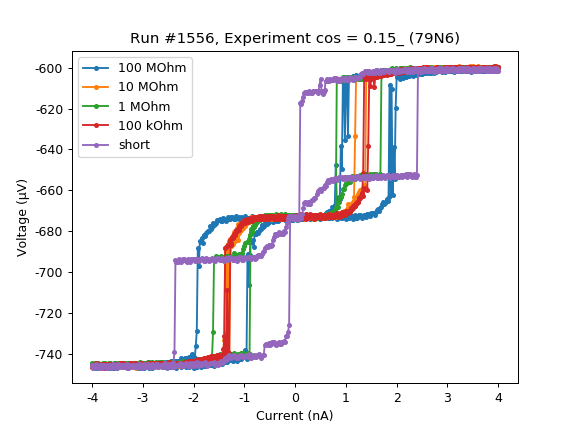

In [172]:
labels = [ '100 MOhm','10 MOhm','1 MOhm','100 kOhm', 'short' ]
batch_plot_by_id([1560, 1559, 1558,1557, 1556],
                 labels = labels, marker = '.', ls = '-')

1. subgap structure for lowest Rload? meas more carefully with fast 6

<IPython.core.display.Javascript object>


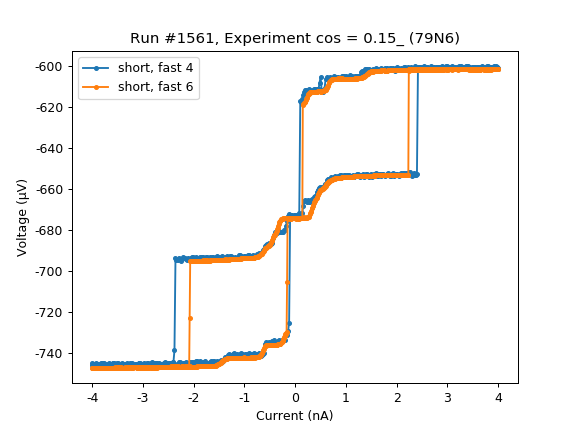

In [185]:
labels = [ 'short, fast 4', 'short, fast 6' ]
batch_plot_by_id([1556, 1561],
                 labels = labels, marker = '.', ls = '-')

ah, may be this is just noise and we should meas everything with fast 6?
no, it was indeed earler jump at fast4. also there are ''near-gap' and 'near supercurrent' states - what's that??

<IPython.core.display.Javascript object>


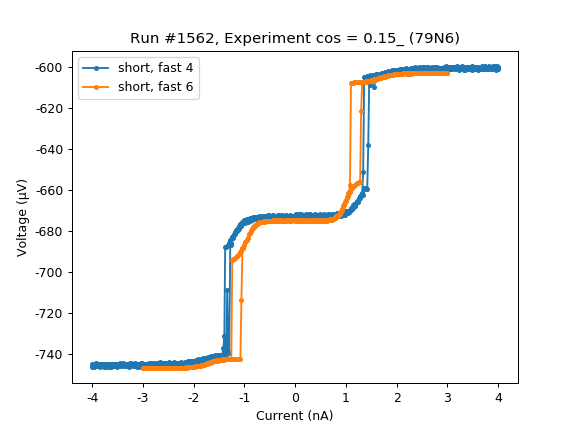

In [189]:
labels = [ 'short, fast 4', 'short, fast 6' ]
batch_plot_by_id([1557, 1562],
                 labels = labels, marker = '.', ls = '-')

Ok, what if we just open box, shunt, remove Rload, put back, close - would we get the same IVc?

<IPython.core.display.Javascript object>


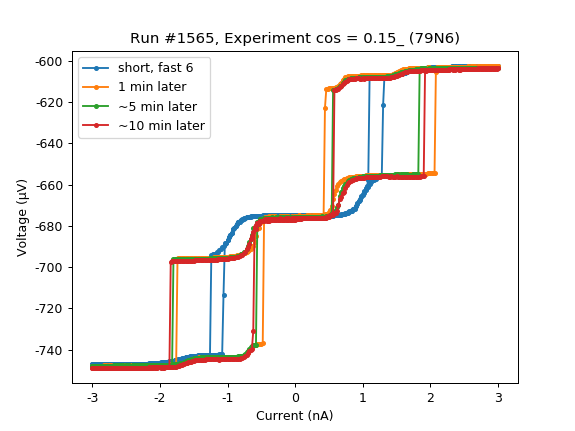

In [200]:
labels = [ '100 kOhm, fast 6', '1 min later',
          '~5 min later', '~10 min later' ]


batch_plot_by_id([1562, 1563, 1564, 1565],
                 labels = labels, marker = '.', ls = '-')

Repeat short (50 Ohm actually)

<IPython.core.display.Javascript object>


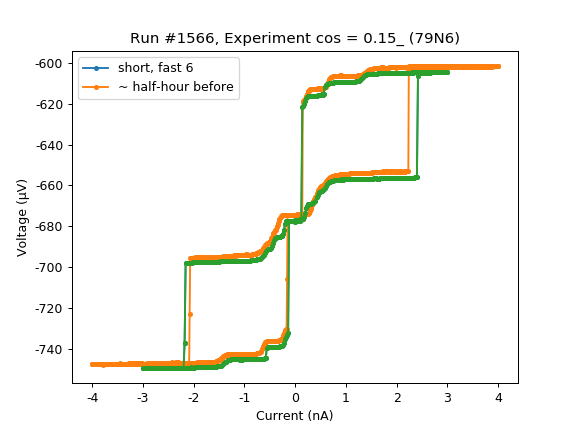

In [345]:
labels = [ 'short, fast 6', '~ half-hour before' ,'' ]


batch_plot_by_id([1566, 1561,1566],
                 labels = labels, marker = '.', ls = '-')

# 12/18 kk
    Cheched and fixed ground loops.
    Plan for today :
    - does ground loop help?
    - keep playing with Kei, how reproducable IVC are
    - AWG with different Rload, same stepsize
    

## full IVC check
    Rload = 50 Ohm

<IPython.core.display.Javascript object>


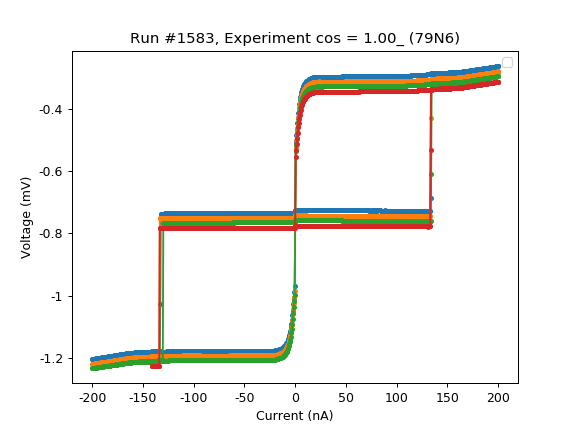

No handles with labels found to put in legend.


In [327]:
batch_plot_by_id([1580,1581,1582,1583], marker = '.', ls = '-')

Drift in the battery baised pre-amp, switch to line

<IPython.core.display.Javascript object>


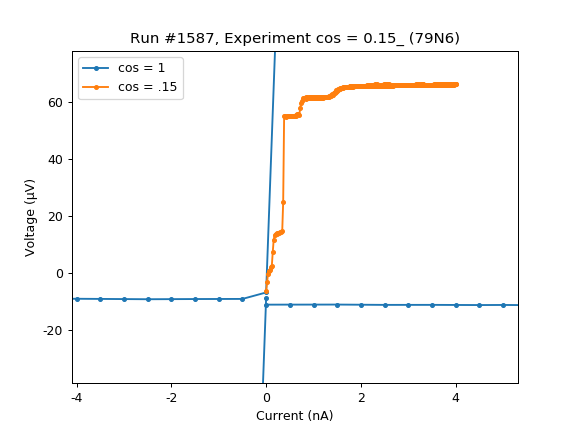

In [340]:
ls = ['cos = 1', 'cos = .15']

batch_plot_by_id([1585,1587], 
                 labels = ls, marker = '.', ls = '-')

Meas 50 Ohm, cos = .15 just several times in raw

<IPython.core.display.Javascript object>


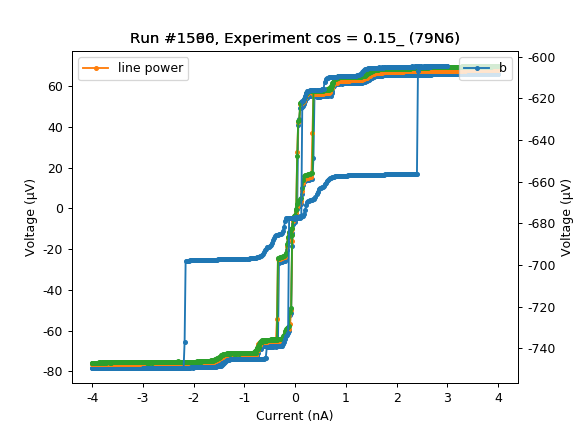

In [374]:
fig, ax = plt.subplots()
ls = '','line power', ''
batch_plot_by_id([1587, 1589, 1590], ax = ax, labels = ls, 
                  marker = '.', ls = '-')

ax2 = ax.twinx()
ls = 'batt power (yesterday)'
batch_plot_by_id([ 1566], ax = ax2, labels = ls,
                  marker = '.', ls = '-')

Big step at 66uV
Sub-steps at 61.5, 55.1, 49?, .., 14, 2.2

Now it's more nnoisy? try open--disconnect-connect-close cycle

No, just a shift of level (why?)

<IPython.core.display.Javascript object>


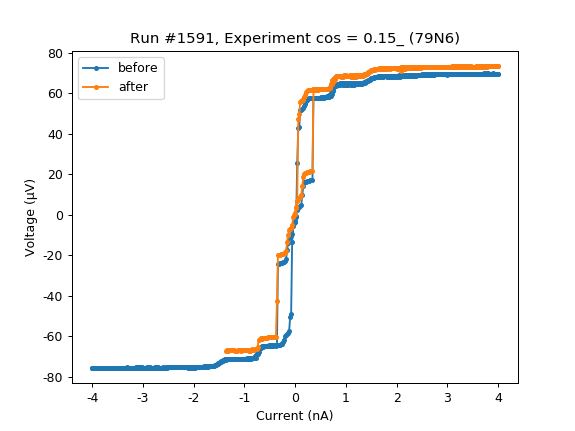

In [378]:
fig, ax = plt.subplots()
ls = 'before','after', ''
batch_plot_by_id([ 1590, 1591], ax = ax, labels = ls, 
                  marker = '.', ls = '-')

let's try different Rload again?



# WS

### 12/16

<IPython.core.display.Javascript object>


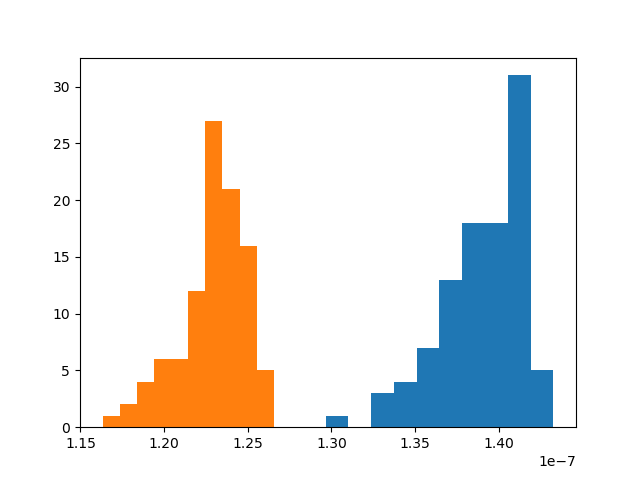

In [22]:
plt.close('all')
f,ax = plt.subplots()
for i in range(1443,1444+1):
    ax.hist(get_data_by_id(i)[0][1]['data'])
plt.show()

In [218]:
def cos_to_B(cos):
    FF_ = .232e-3
    ZF_ = .004e-3
    return np.arccos( cos)*(2* (FF_ - ZF_)/np.pi + ZF_  )

<IPython.core.display.Javascript object>


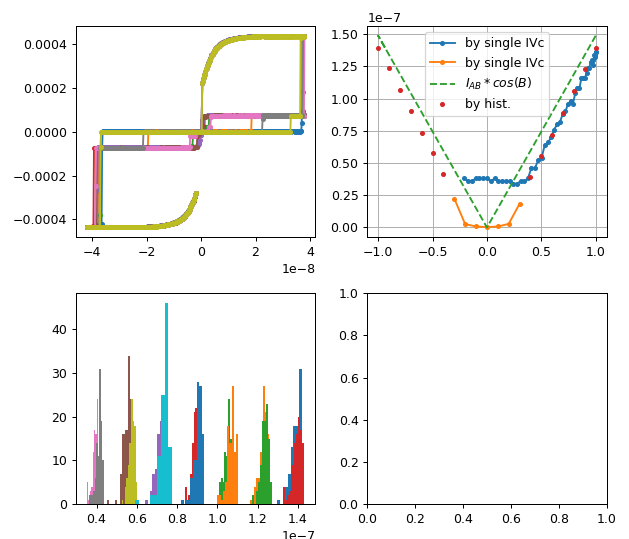

In [274]:
plt.close('all')
f,ax=plt.subplots(2,2, figsize=(7,6))
ax = ax.flatten()

Iclstp = np.asarray([])
Blst = np.linspace(ZF, ZF + 1.0*dF, 51)
for i,v in enumerate(range(763,813+1)):
    data = get_data_by_id(v)
    Is = data[0][0]['data']
    Vs = data[0][1]['data']-data[0][1]['data'][0]
    for j,w in enumerate(np.diff(Vs)):
        if abs(w) > 1e-4:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
ax[1].plot(np.cos(Blst/FF*np.pi/2), Iclstp, '.', ls='-', label = 'by single IVc')

Iclstp = np.asarray([])
Blst = cos_to_B(np.linspace(0.4,-0.4,9))
for i,v in enumerate(range(1458,1466+1)):#range(1458,1466+1) 1468,1458,
    data = get_data_by_id(v)
    Is = data[0][0]['data'][9:]
    Vs = data[0][1]['data']-data[0][1]['data'][-1]-0.28e-3
    Vs = Vs[9:]
    ax[0].plot(Is,Vs,ls='-',marker='.')
    for j,w in enumerate(np.diff(Vs)):
        if abs(w) > 1.5e-5:
            Iclstp = np.append(Iclstp,np.abs(Is[j]))
            break
            
ax[1].plot(np.linspace(0.3,-0.3,7), Iclstp[1:-1], '.', ls='-', label = 'by single IVc')
Blst = np.linspace(ZF, ZF + 2.0*dF, 51)
ax[1].plot(np.cos(Blst/FF*np.pi/2),148.8e-9*np.abs(np.cos(Blst/FF*np.pi/2)),'--', label = '$I_{AB}*cos(B)$')

Iclst = []
for i in range(1443,1456+1):
    Ic = get_data_by_id(i)[0][1]['data']
#     ax[1].hist(Ic)
    Iclst.append(Ic.mean())
ax[1].plot(np.asarray([np.linspace(1.0,0.4,7), np.linspace(-0.4,-1.0,7)]).flatten(), Iclst,'.', label = 'by hist.')

ax[1].legend()
ax[1].grid()
ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))
plt.tight_layout()
plt.show()


for i in range(1443,1456+1):
    Ic = get_data_by_id(i)[0][1]['data']
    ax[2].hist(Ic)

<IPython.core.display.Javascript object>


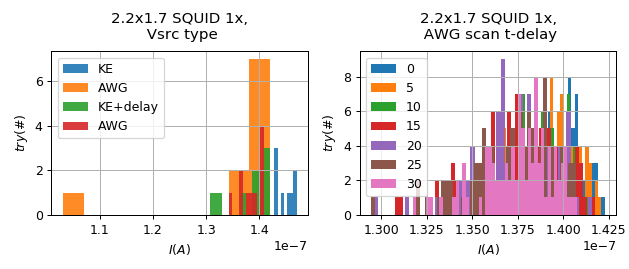

[1.46400000e-07 1.45840000e-07 1.41012000e-07 1.42841733e-07
 1.43202343e-07 1.41185922e-07 1.45541367e-07 1.43371762e-07
 1.44167439e-07 1.46972917e-07]
[1.38600000e-07 1.35260000e-07 1.38893000e-07 1.36358433e-07
 1.03127786e-07 1.40044784e-07 1.38804733e-07 1.40101268e-07
 1.41989875e-07 1.39279776e-07]
[1.30800000e-07 1.41080000e-07 1.36994000e-07 1.42029133e-07
 1.32372578e-07 1.39065514e-07 1.39905687e-07 1.39546384e-07
 1.41772416e-07 1.40617397e-07]
[1.40800000e-07 1.40480000e-07 1.40464000e-07 1.34258133e-07
 1.36500053e-07 1.39050044e-07 1.38459204e-07 1.37657306e-07
 1.36445859e-07 1.40423496e-07]


In [275]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))
ax = ax.flatten()

label = ['KE', 'AWG', 'KE+delay', 'AWG','','']
for i,v in enumerate([1397,1398, 1399, 1400]):#fast 4, fast
    data = get_data_by_id(v)
    Ic = data[0][1]['data']
    print(Ic)
    ax[0].hist(Ic, bins=10, label = label[i], alpha = 0.9)

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$try (\#)$')
ax[0].set_title('2.2x1.7 SQUID 1x,\n Vsrc type', pad=10)
ax[0].grid()
ax[0].legend()
# ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

label =  range(0,35,5)
for i,v in enumerate(range(1408,1414+1)):#fast 4, fast 1401,1407+1
    data = get_data_by_id(v)
    Ic = data[0][1]['data']
#     print(Ic)
#     ax[0].plot(Ic,np.linspace(0,9,10))
    ax[1].hist(Ic, bins=50, label = label[i], alpha = 1)

ax[1].set_xlabel('$I (A)$')
ax[1].set_ylabel('$try (\#)$')
ax[1].set_title('2.2x1.7 SQUID 1x,\n AWG scan t-delay', pad=10)
# ax[1].set_ylim(0,5)
ax[1].grid()
ax[1].legend()
# ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

### 12/17

<IPython.core.display.Javascript object>


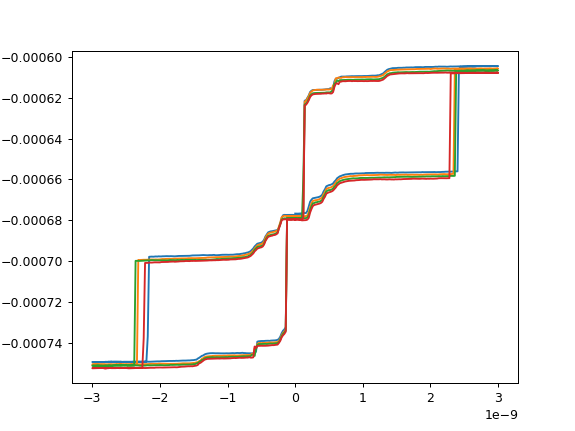

In [208]:
#fast 6
plt.close('all')
f,ax = plt.subplots()
for i in range(1566,1569+1):
    ax.plot(get_data_by_id(i)[0][0]['data'],
            get_data_by_id(i)[0][1]['data'], '-')
plt.show()

<IPython.core.display.Javascript object>


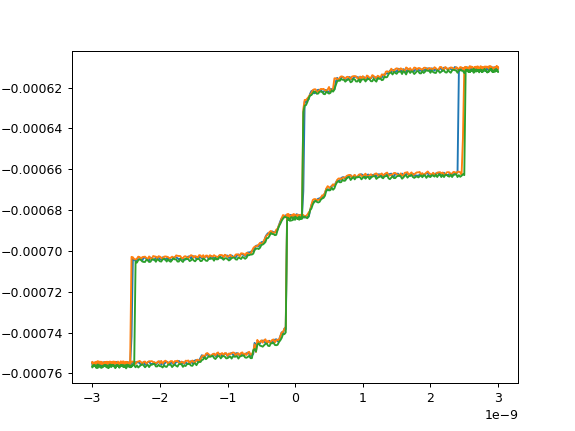

In [225]:
#fast 4
plt.close('all')
f,ax = plt.subplots()
for i in range(1570,1572+1):
    ax.plot(get_data_by_id(i)[0][0]['data'],
            get_data_by_id(i)[0][1]['data'], '-')
plt.show()

<IPython.core.display.Javascript object>


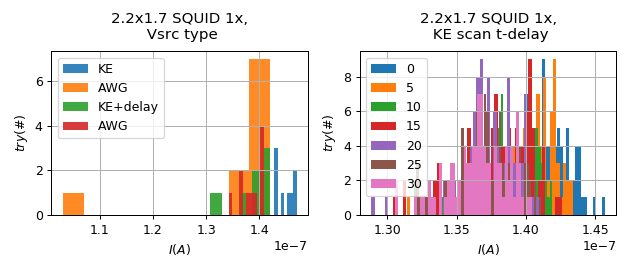

[1.46400000e-07 1.45840000e-07 1.41012000e-07 1.42841733e-07
 1.43202343e-07 1.41185922e-07 1.45541367e-07 1.43371762e-07
 1.44167439e-07 1.46972917e-07]
[1.38600000e-07 1.35260000e-07 1.38893000e-07 1.36358433e-07
 1.03127786e-07 1.40044784e-07 1.38804733e-07 1.40101268e-07
 1.41989875e-07 1.39279776e-07]
[1.30800000e-07 1.41080000e-07 1.36994000e-07 1.42029133e-07
 1.32372578e-07 1.39065514e-07 1.39905687e-07 1.39546384e-07
 1.41772416e-07 1.40617397e-07]
[1.40800000e-07 1.40480000e-07 1.40464000e-07 1.34258133e-07
 1.36500053e-07 1.39050044e-07 1.38459204e-07 1.37657306e-07
 1.36445859e-07 1.40423496e-07]


In [282]:
SAMPLE = '79N6' #3ab,4ab
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

plt.close('all')
f,ax=plt.subplots(1,2, figsize=(7,3))
ax = ax.flatten()

label = ['KE', 'AWG', 'KE+delay', 'AWG','','']
for i,v in enumerate([1397,1398, 1399, 1400]):#fast 4, fast
    data = get_data_by_id(v)
    Ic = data[0][1]['data']
    print(Ic)
    ax[0].hist(Ic, bins=10, label = label[i], alpha = 0.9)

ax[0].set_xlabel('$I (A)$')
ax[0].set_ylabel('$try (\#)$')
ax[0].set_title('2.2x1.7 SQUID 1x,\n Vsrc type', pad=10)
ax[0].grid()
ax[0].legend()
# ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

label =  range(0,35,5)
for i,v in enumerate(range(1573,1579+1)):#fast 4, fast 1401,1407+1
    data = get_data_by_id(v)
    Ic = data[0][1]['data']
#     print(Ic)
#     ax[0].plot(Ic,np.linspace(0,9,10))
    ax[1].hist(Ic, bins=50, label = label[i], alpha = 1)

ax[1].set_xlabel('$I (A)$')
ax[1].set_ylabel('$try (\#)$')
ax[1].set_title('2.2x1.7 SQUID 1x,\n KE scan t-delay', pad=10)
# ax[1].set_ylim(0,5)
ax[1].grid()
ax[1].legend()
# ax[1].ticklabel_format(axis='both', style='sci', scilimits=(0, 2))

plt.tight_layout()

In [331]:
 for idx in range(1573,1579+1):
        Ic0, Teff = fit_hist_by_id(idx, EJ = 2, Ec = 0.05, bins = 21)
        
        print( 'Run id {:.0f},Ic0 = {:2.1f}nA, Teff = {:2.0f}mK )'.format(idx, Ic0*1e9, Teff*1e3))

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


Run id 1573,Ic0 = 198.8nA, Teff = 73mK )
Run id 1574,Ic0 = 190.3nA, Teff = 62mK )
Run id 1575,Ic0 = 191.4nA, Teff = 66mK )
Run id 1576,Ic0 = 204.7nA, Teff = 90mK )
Run id 1577,Ic0 = 192.8nA, Teff = 71mK )
Run id 1578,Ic0 = 190.5nA, Teff = 67mK )
Run id 1579,Ic0 = 189.7nA, Teff = 66mK )
